# About this notebook
Notebook is used for experimenting the subtasks "grouping categorical features" and "feature selection".
Functions will then be modularized used in `data_cleaning.py` or `feature_selection.py`.

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import mutual_info_classif

sns.set_theme(style="whitegrid")
sns.set_palette(palette="Paired")

# Load Data

In [2]:
# Read provided data
x_train = pd.read_csv("../../data/raw/train_values.csv")
y_train = pd.read_csv("../../data/raw/train_labels.csv")
x_test = pd.read_csv("../../data/raw/test_values.csv")

x_train.set_index("building_id", inplace=True)
x_test.set_index("building_id", inplace=True)
y_train.set_index("building_id", inplace=True)

# Concat x_train and y_train for analysis: Drop building_id since its redundant then
df_train = pd.concat([x_train, y_train], axis=1)

# Print information about shape
print(f"Shape of train_values.csv: {x_train.shape}")
print(f"Shape of train_labels.csv: {y_train.shape}")
print(f"Shape of concat df_train to analyse: {df_train.shape}")

# Preview df
df_train.head(5)

Shape of train_values.csv: (260601, 38)
Shape of train_labels.csv: (260601, 1)
Shape of concat df_train to analyse: (260601, 39)


,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,3
28830,8,900,2812,2,10,8,7,o,r,n,...,0,0,0,0,0,0,0,0,0,2
94947,21,363,8973,2,10,5,5,t,r,n,...,0,0,0,0,0,0,0,0,0,3
590882,22,418,10694,2,10,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,2
201944,11,131,1488,3,30,8,9,t,r,n,...,0,0,0,0,0,0,0,0,0,3


# Grouping of categorical features

## Plot distribution of categorical features
We need this plot to do the mapping.

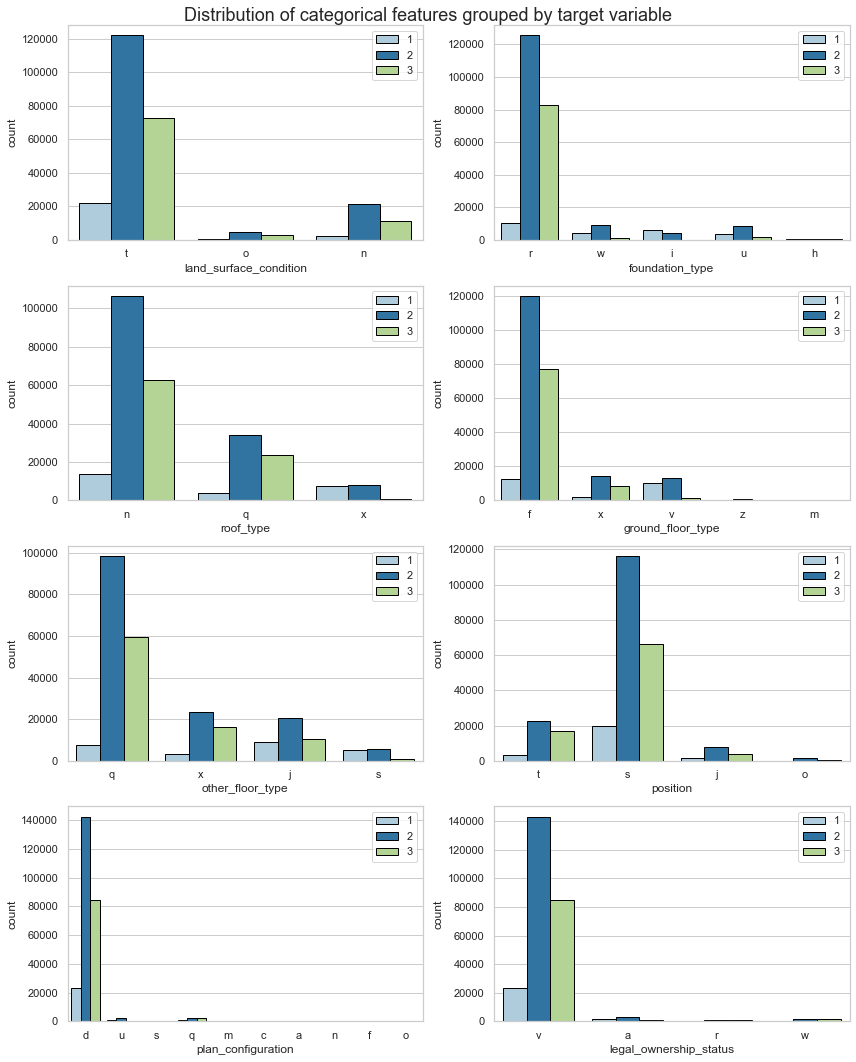

In [3]:
# First get columns to analyse (here: categorical ones)
categoric_columns = list(df_train.select_dtypes(include=['object']).columns)#.remove("building_id")
categoric_columns = categoric_columns + ["damage_grade"]
df_train_categoric = df_train[categoric_columns]
categoric_columns_wo_target = [x for x in categoric_columns if x != "damage_grade"]

# Dynamically set size of subplots
NCOLS: int = 2
NROWS: int = math.ceil(len(categoric_columns_wo_target)/NCOLS)

# Plot settings
fig, axes = plt.subplots(figsize=(12, 15), nrows=NROWS, ncols=NCOLS)
fig.suptitle("Distribution of categorical features grouped by target variable", size=18)
for feature, ax in zip(categoric_columns_wo_target, axes.flatten()):
    g=sns.countplot(data=df_train_categoric, x=feature, hue="damage_grade", edgecolor="black", ax=ax)
    ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

### Findings
Do mapping for
- plan_configuration
- legal_ownership_status
- ground_floor_type

## Define mappings and map function

In [4]:
def group_categorical_features(df: pd.DataFrame, default_val: str = "others", verbose: bool = False) -> pd.DataFrame:
    """
    Function that groups categorical features with many unique low populated realizations into "others".
    Significant for feature that have rarely occurring categorical values, e.g. "plan_configuration".
    Predefined mappings are within the function and contain the column to apply the mapping and the map itself.
    Not explicitly listed mappings are replaced with param "default_val", which is "others" (default)

    :param df: DataFrame to apply the mapping
    :param default_val: Default value to use for not explicit listed maps
    :param verbose: Bool whether to print information or not (default: False)

    :return: DataFrame with the column replaced with the mapped column
    """

    # Define mapping for each feature with rarely occuring categorical values
    mapping_plan_configuration = {"col": "plan_configuration",
                                  "mapping": {"d": "d"}}
    mapping_legal_ownership_status = {"col": "legal_ownership_status",
                                      "mapping": {"v": "v"}}
    mapping_ground_floor_type = {"col": "ground_floor_type",
                                 "mapping": {"f": "f", "x": "x", "v": "v"}}
    # Put in list for iteration
    mappings = [mapping_plan_configuration, mapping_legal_ownership_status, mapping_ground_floor_type]

    # Apply mapping for each mapping defined in mappings list
    for mapping in mappings:
        # Overwrite column to be mapped with mapped values
        df[mapping.get("col")] = df[mapping.get("col")].map(mapping.get("mapping")).fillna(default_val)
        if verbose:
            print(f"Applied mapping / grouping for feature '{mapping.get('col')}'")
    return df

df = df_train.copy()
df = group_categorical_features(df=df, default_val="others", verbose=True)

Applied mapping / grouping for feature 'plan_configuration'
Applied mapping / grouping for feature 'legal_ownership_status'
Applied mapping / grouping for feature 'ground_floor_type'


## Plot after Mapping

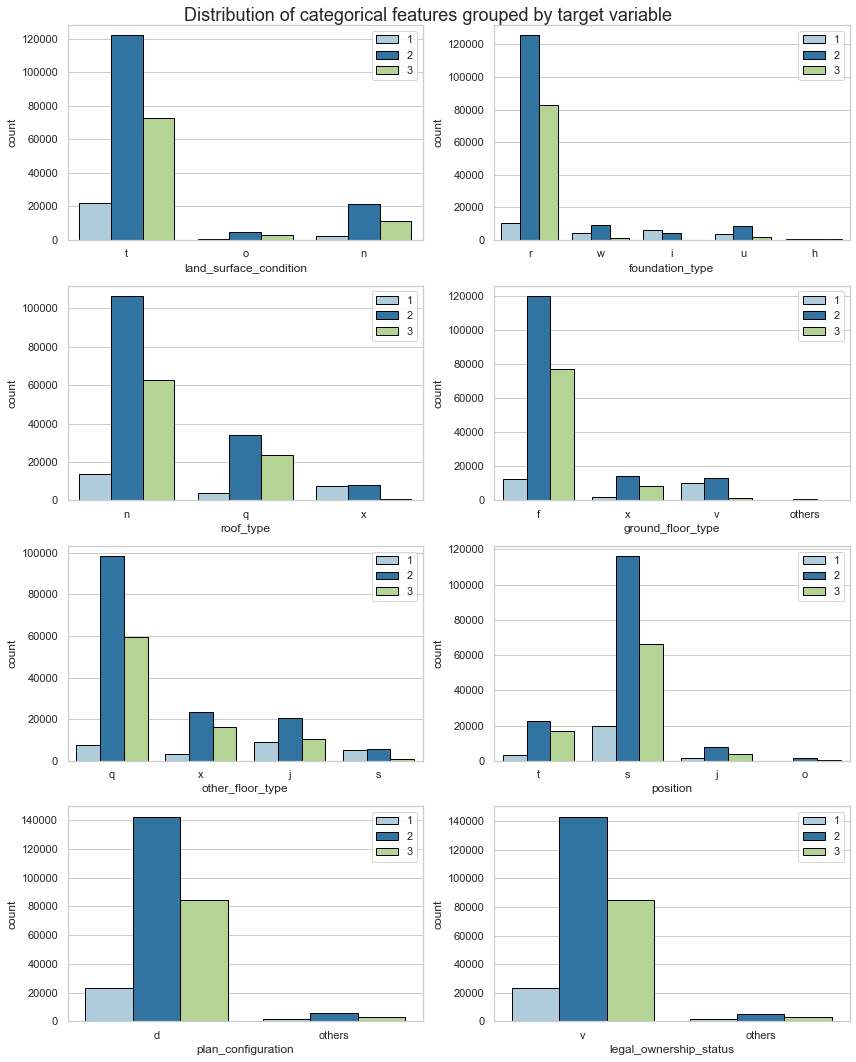

In [5]:
# Dynamically set size of subplots
NCOLS: int = 2
NROWS: int = math.ceil(len(categoric_columns_wo_target)/NCOLS)

# Plot settings
fig, axes = plt.subplots(figsize=(12, 15), nrows=NROWS, ncols=NCOLS)
fig.suptitle("Distribution of categorical features grouped by target variable", size=18)
for feature, ax in zip(categoric_columns_wo_target, axes.flatten()):
    g=sns.countplot(data=df, x=feature, hue="damage_grade", edgecolor="black", ax=ax)
    ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

_____
# Feature Selection using RFE

In [6]:
# Get train data and prepare for feature selection
x_train = group_categorical_features(x_train)

In [7]:
# Do some label encoding here for feature selection
x_train = pd.get_dummies(x_train)

# Make x_train and y_train bit smaller for my laptop to handle :-)
x_train = x_train.sample(frac=0.5)
y_train = y_train.loc[x_train.index]
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

x_train.head(5)

Shape of x_train: (130300, 57)
Shape of y_train: (130300, 1)


,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_d,plan_configuration_others,legal_ownership_status_others,legal_ownership_status_v
building_id,,,,,,,,,,,,,,,,,,,,,
488036,27,548,4430,3,50,4,9,0,0,0,...,0,1,0,1,0,0,1,0,0,1
67130,8,1225,6127,2,0,6,5,0,1,0,...,0,0,0,0,1,0,1,0,0,1
767720,26,740,5177,3,60,9,7,0,1,0,...,0,0,0,0,1,0,1,0,0,1
814511,10,1097,12171,2,15,5,4,0,1,0,...,0,0,0,0,1,0,1,0,0,1
943148,3,1387,3863,5,80,7,11,0,0,0,...,0,0,1,0,0,0,1,0,0,1


In [8]:
y_train.head(5)

,damage_grade
building_id,
488036,3
67130,3
767720,2
814511,2
943148,2


In [13]:
def get_top_k_features_using_rfe(x_train: pd.DataFrame, y_train: pd.DataFrame, k = 0.50, step: int = 2, verbose: int = 0):
    """
    Applies Recursive Feature Elimination to get the best k features. Note that k can either be a integer, or a float.
    If it is a float, e.g. 0.5, then 50% of the total features, that are estimated to be relevant, will be selected.
    Uses a RandomForest as a classifier and therefore the _feature_importances as a scoring.

    :param x_train: DataFrame of the training data
    :param y_train: Dataframe of the labels
    :param k: Int or float: Number of features to be selected. The smaller it is, the more computation power is needed.
    :param step: Step size of the feature elimination. The smaller it is, the more computation power is needed.
    :param verbose: Verbosity level. Set to 0 to be quiet.

    :return: List of k top features, Fitted RFE object
    """

    # Define classifier
    clf = RandomForestClassifier()
    rfe = RFE(estimator=clf, n_features_to_select=k, step=step, verbose=verbose)
    rfe.fit(x_train, y_train["damage_grade"].values.flatten())

    # Select feature name that are estimated to be the best features
    ranking = pd.DataFrame({"feature": x_train.columns, "rfe_support": rfe.support_})
    best_k_features = ranking[ranking["rfe_support"] == True]["feature"].to_list()

    return best_k_features, rfe


def get_top_k_features_using_rfe_cv(x_train: pd.DataFrame,
                                    y_train: pd.DataFrame,
                                    min_features_to_select=20,
                                    k_folds=5, scoring="matthews_corrcoef",
                                    step=2, verbose=0):
    """
    Applies Recursive Feature Elimination RFE with cross validation. As the estimator and thus the scoring, we use
    RandomForests respectively feauture_importance. CV is used via StratifiedKFold since we got an imbalanced target.

    :param x_train: DataFrame of the training data
    :param y_train: Dataframe of the labels
    :param min_features_to_select: Minimum number of features to keep
    :param k_folds: Number of folds in each CV
    :param scoring: Scoring metric, e.g. 'accuracy' (default is MCC)
    :param step: Step size of the RFE
    :param verbose: Verbosity level
    :return: List of k top features and fitted RFECV Object
    """

    # Define classifier
    clf = RandomForestClassifier()
    rfecv = RFECV(estimator=clf,
                  min_features_to_select=min_features_to_select,
                  cv=StratifiedKFold(k_folds),
                  scoring=scoring,
                  step=step,
                  n_jobs=-1,
                  verbose=verbose)
    rfecv.fit(x_train, y_train["damage_grade"].values.flatten())

    # Select feature name that are estimated to be the best features
    ranking = pd.DataFrame({"feature": x_train.columns, "rfecv_support": rfecv.support_})
    best_k_features = ranking[ranking["rfecv_support"] == True]["feature"].to_list()

    return best_k_features, rfecv

#best_k_features, rfe = get_top_k_features_using_rfe(x_train=x_train, y_train=y_train, k=0.75, verbose=1)
# Or use CV
best_k_features, rfecv = get_top_k_features_using_rfe_cv(x_train=x_train,
                                                         y_train=y_train,
                                                         min_features_to_select=40,
                                                         k_folds=3,
                                                         scoring="matthews_corrcoef",
                                                         step=5,
                                                         verbose=1)

Fitting estimator with 57 features.
Fitting estimator with 52 features.
Fitting estimator with 47 features.
Fitting estimator with 42 features.


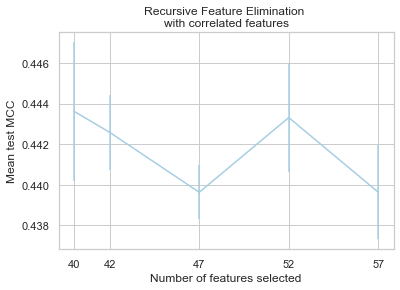

In [106]:
n_scores = len(rfecv.cv_results_["mean_test_score"])

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test MCC")
plt.errorbar(
    [40, 42, 47, 52, 57], #Should be [40, 42, 47, 52, 57]
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.xticks([40, 42, 47, 52, 57])
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

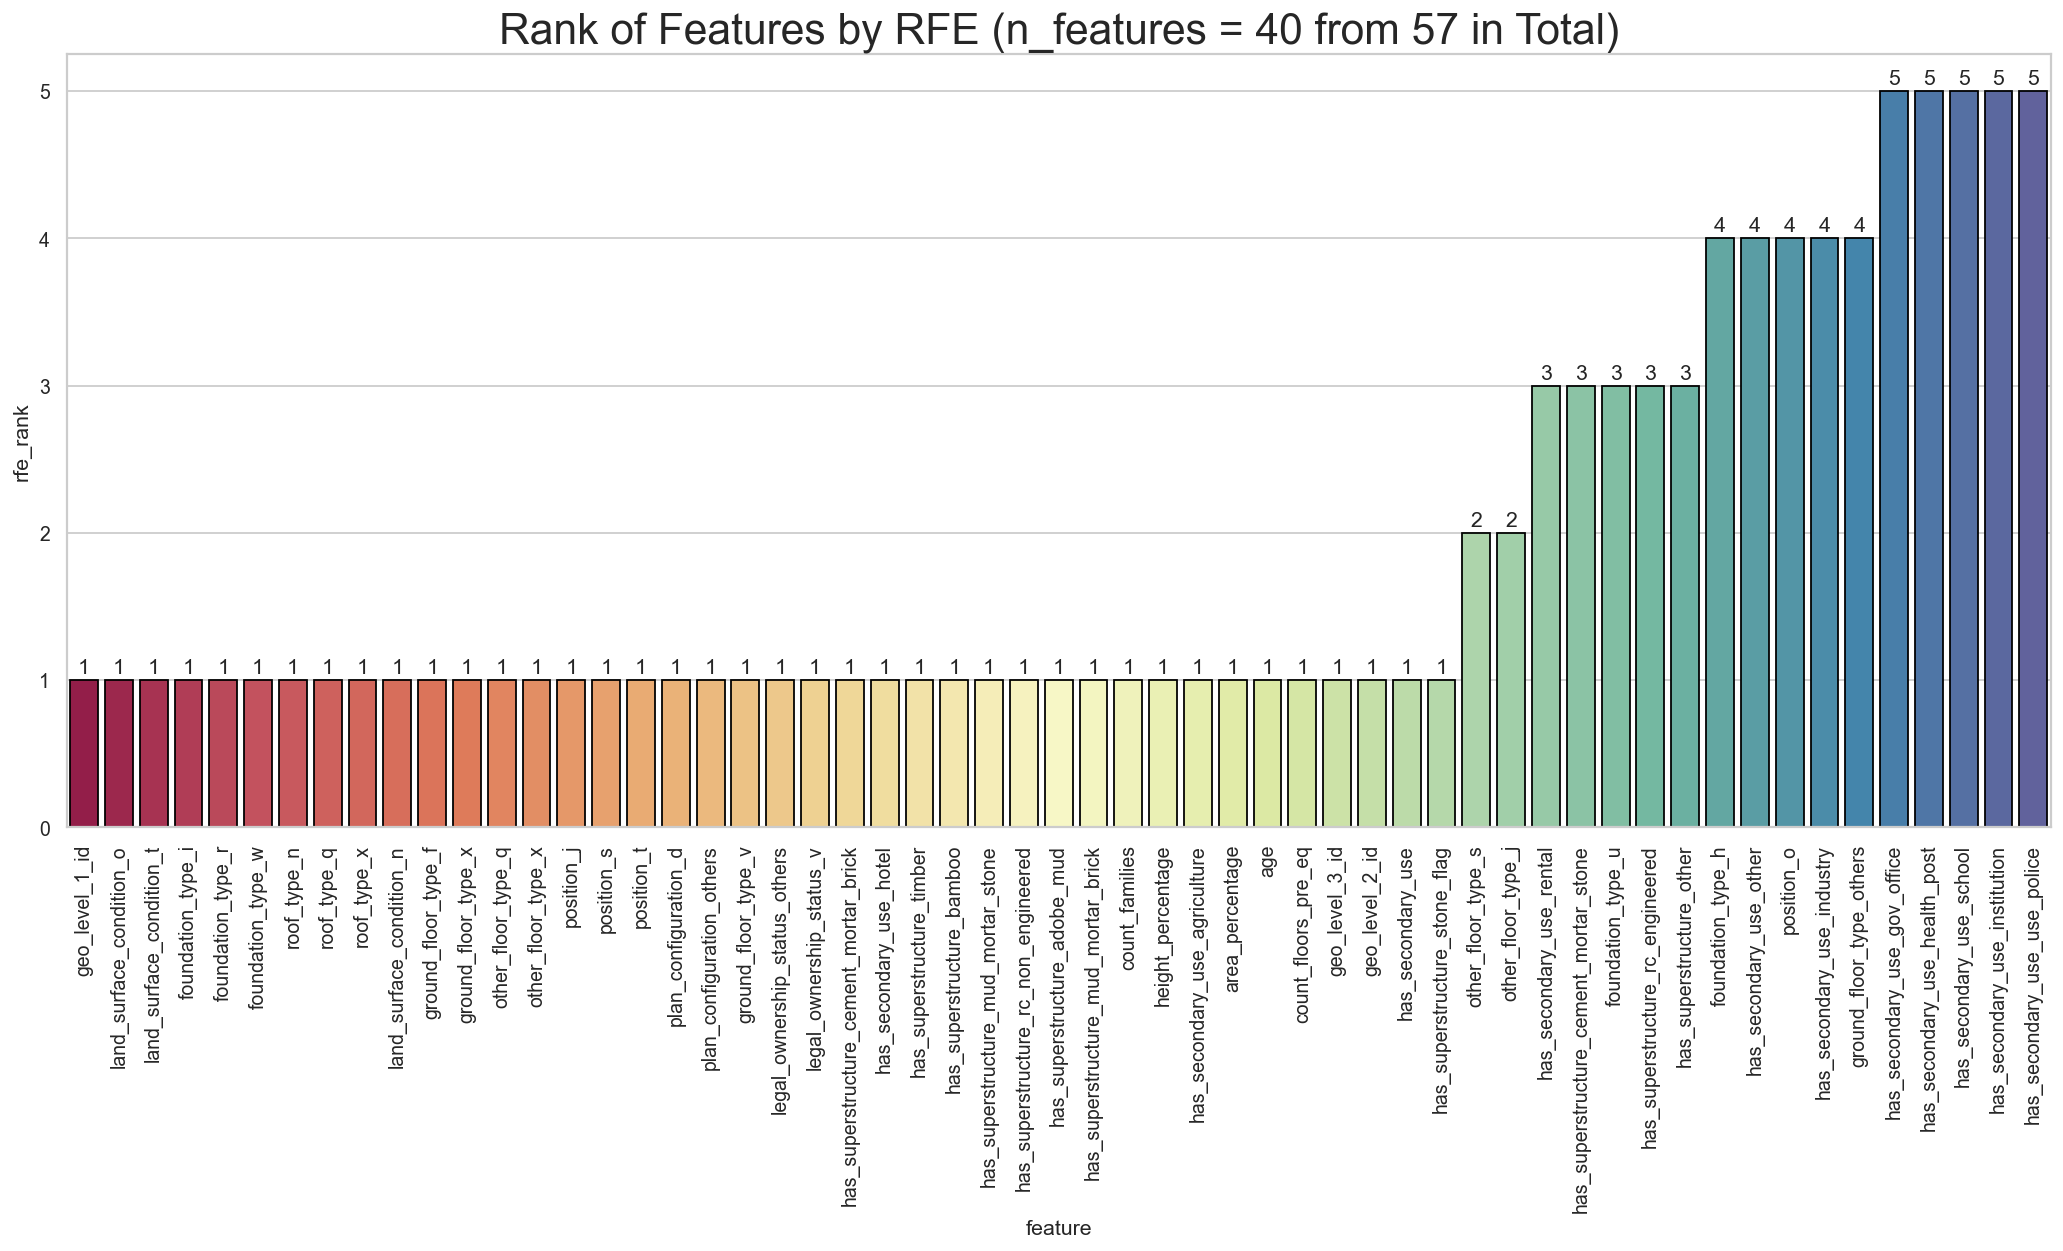

In [52]:
def plot_rfe_ranking(rfe):
    """
    Plots results from RFE or RFECV, i.e. feature and its rank in barplot.

    :param rfe: Fitted RFE / RFECV object
    :return: None
    """

    # Create dataframe for plotting
    res = pd.DataFrame({"feature": rfe.feature_names_in_, "rfe_rank": rfe.ranking_})
    res = res.sort_values(by="rfe_rank")

    # Plot settings
    plt.figure(figsize=(20, 8), dpi=128)
    plt.title(f"Rank of Features by RFE (n_features = {rfe.n_features_} from {rfe.n_features_in_} in Total)", size=24)
    g = sns.barplot(data=res, x="feature", y="rfe_rank", edgecolor="black", palette="Spectral")
    plt.xticks(rotation=90)
    plt.bar_label(g.containers[0], padding=1.5)
    plt.show()

#plot_rfe_ranking(rfe)
plot_rfe_ranking(rfecv)

# Feature Selection using Mutual Information
In comparison to RFE, Feature Selection using Mutual Information is much less computational heavy.

In [53]:
def get_top_k_features_using_mi(x_train: pd.DataFrame, y_train: pd.DataFrame, k: int = 30):
    """
    Computes the Mutual Information to the label and outputs the top k features as a list

    :param x_train: DataFrame of the train values
    :param y_train: DataFrame of the labels
    :param k: Number of top k features to output as list

    :return: List of top k features based on Mutual Information score
    """

    # Compute mutual information scores
    mi_scores = mutual_info_classif(x_train, y_train["damage_grade"].values.flatten())
    mi_scores = pd.Series(mi_scores)
    mi_scores.index = x_train.columns

    # Sorts descending based on mi score and gets k first features
    top_k_features =  mi_scores.sort_values(ascending=False)[: k].keys().tolist()

    return top_k_features, mi_scores

top_k_features_mi, mi_scores = get_top_k_features_using_mi(x_train, y_train)

In [54]:
def get_comparison_df_rfe_mi(rfe: RFE, mi_scores: list, sort_by = "mi_score", ascending=False):
    ""
    comparison = pd.DataFrame({"rfe_rank": rfe.ranking_, "mi_score": mi_scores})
    comparison.sort_values(by=sort_by, ascending=ascending, inplace=True)

    return comparison

#get_comparison_df_rfe_mi(rfe=rfe, mi_scores=mi_scores, sort_by="mi_score")
get_comparison_df_rfe_mi(rfe=rfecv, mi_scores=mi_scores, sort_by="mi_score")

,rfe_rank,mi_score
geo_level_3_id,1,0.291390
geo_level_2_id,1,0.234748
geo_level_1_id,1,0.135432
foundation_type_r,1,0.072261
has_superstructure_mud_mortar_stone,1,0.057531
ground_floor_type_v,1,0.052663
ground_floor_type_f,1,0.041317
roof_type_x,1,0.039667
foundation_type_i,1,0.035910
has_superstructure_cement_mortar_brick,1,0.033623


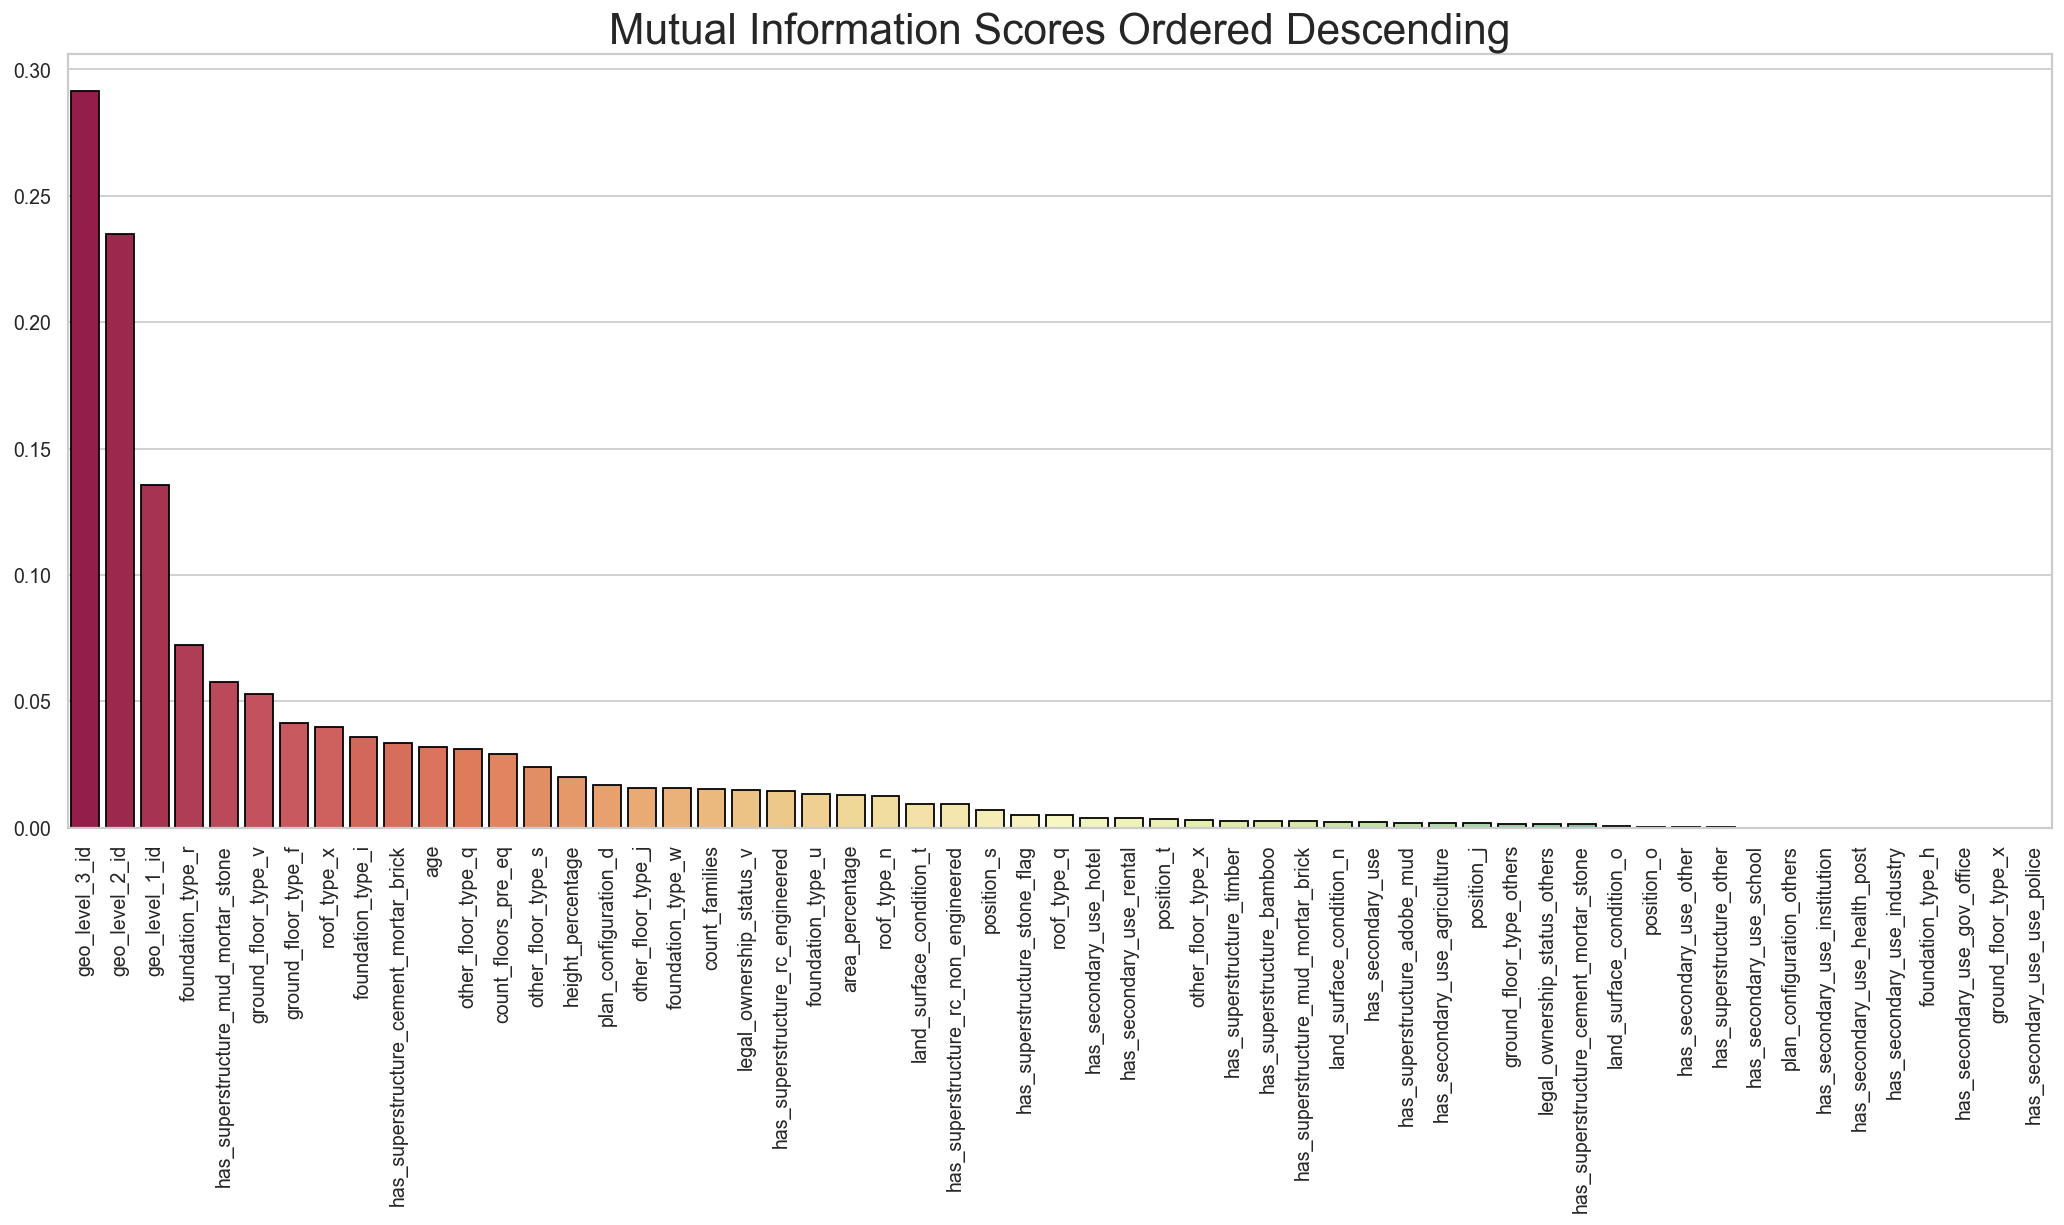

In [55]:
def plot_mi_ranking(mi_scores):
    """
    Plots results of the Mutual Information Score.

    :param mi_scores: Pandas Series -- Output of the get_top_k_features_using_mi function
    :return: None
    """

    mi_scores.sort_values(ascending=False, inplace=True)
    plt.figure(figsize=(20,8), dpi=128)
    plt.title("Mutual Information Scores Ordered Descending", size=24)
    g = sns.barplot(x=mi_scores.keys(), y=mi_scores.values, palette="Spectral", edgecolor="black")
    plt.xticks(rotation=90)
    plt.show()

plot_mi_ranking(mi_scores)